In [1]:
%load_ext autoreload
%autoreload 2

# Preprocess MovieLens20M

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import scipy.sparse

import teaser.util as util

In [3]:
DATA_DIR = Path('../../data/ML20M/raw')

# Parsing
INTERACTIONS_PATH = DATA_DIR / 'ratings.csv'
ITEMS_PATH = DATA_DIR / 'movies.csv'
TAGS_PATH = DATA_DIR / 'tags.csv'
IMDB_ID_PATH = DATA_DIR / 'links.csv'
IMDB_BASICS_PATH = DATA_DIR / 'title.basics.tsv'
IMDB_CREW_PATH = DATA_DIR / 'title.crew.tsv'

# Parse ids
ITEM_ID = 'movieId'
USER_ID = 'userId'
RATING_ID = 'rating'

# For output
T_ITEM_ID = 'itemId'
T_USER_ID = 'userId'

OUTPUT_DIR = Path('../../data/ML20M/')
OUTPUT_INTERACTIONS_PATH = OUTPUT_DIR / 'interactions.csv'
OUTPUT_FEATURES_PATH = OUTPUT_DIR / 'features.csv'

# For preprocessing
# MIN_USERS_PER_ITEM = 5
# MIN_ITEMS_PER_USER = 5

# For split
AMT_VAL_USERS = 10000
AMT_TEST_USERS = 10000
PERC_HISTORY = 0.8
VAL_MIN_ITEMS_PER_USER = 5   # Make sure only users with at least this many items are selected for validation

# For reproducibility
SEED = 42

## Parse interaction data

In [4]:
interactions = pd.read_csv(INTERACTIONS_PATH, usecols=[USER_ID, ITEM_ID, RATING_ID])
interactions

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5
...,...,...,...
20000258,138493,68954,4.5
20000259,138493,69526,4.5
20000260,138493,69644,3.0
20000261,138493,70286,5.0


In [5]:
# Only counts ratings of 4 or higher as positive
interactions = interactions[interactions[RATING_ID] >= 4]
interactions.drop(columns=[RATING_ID], inplace=True)
interactions

/home/joey/Documents/Informatica/PhD/2020-2021/SI EDLAE/Code/env/lib/python3.8/site-packages/pandas/core/frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,userId,movieId
6,1,151
7,1,223
8,1,253
9,1,260
10,1,293
...,...,...
20000256,138493,66762
20000257,138493,68319
20000258,138493,68954
20000259,138493,69526


## Filter users and items

In [6]:
# item_counts = interactions.value_counts(ITEM_ID)
# remaining_items = set(item_counts.index[item_counts > MIN_USERS_PER_ITEM])
# interactions = interactions[interactions[ITEM_ID].isin(remaining_items)]

In [7]:
# user_counts = interactions.value_counts(USER_ID)
# remaining_users = set(user_counts.index[user_counts > MIN_ITEMS_PER_USER])
# interactions = interactions[interactions[USER_ID].isin(remaining_users)]

In [8]:
# Might have some items with less than MIN_USERS_PER_ITEM users because the users could have been removed
interactions.value_counts(ITEM_ID)

movieId
318      55807
296      52353
593      50114
356      47331
260      42612
         ...  
83310        1
83320        1
83339        1
83376        1
42550        1
Length: 20720, dtype: int64

In [9]:
interactions.value_counts(USER_ID)

userId
125794    3177
82418     2655
8405      2503
118205    2377
131894    2349
          ... 
93335        1
27120        1
32451        1
53274        1
66596        1
Length: 138287, dtype: int64

In [10]:
used_items = set(interactions[ITEM_ID])
# used_items

## Parse metadata

In [11]:
items = pd.read_csv(ITEMS_PATH, usecols=[ITEM_ID, 'genres'])  # don't need title
print("Original items:", len(items))
# Only keep metadata of used items
items = items[items[ITEM_ID].isin(used_items)]
items['genres'].replace('(no genres listed)', "", inplace=True)
items

Original items: 27278


,movieId,genres
0,1,Adventure|Animation|Children|Comedy|Fantasy
1,2,Adventure|Children|Fantasy
2,3,Comedy|Romance
3,4,Comedy|Drama|Romance
4,5,Comedy
...,...,...
27271,131250,Comedy
27272,131252,Comedy|Horror
27273,131254,Comedy
27274,131256,Comedy


In [12]:
items['genres'] = items['genres'].apply(lambda x: x.split('|') if len(x) > 0 else list())
items['genres']

0        [Adventure, Animation, Children, Comedy, Fantasy]
1                           [Adventure, Children, Fantasy]
2                                        [Comedy, Romance]
3                                 [Comedy, Drama, Romance]
4                                                 [Comedy]
                               ...                        
27271                                             [Comedy]
27272                                     [Comedy, Horror]
27273                                             [Comedy]
27274                                             [Comedy]
27277                         [Adventure, Fantasy, Horror]
Name: genres, Length: 20720, dtype: object

In [13]:
items['genres'].explode().unique()

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Western', 'Film-Noir', nan], dtype=object)

### Tags

In [14]:
tags = pd.read_csv(TAGS_PATH, usecols=[ITEM_ID, 'tag'])
tags

,movieId,tag
0,4141,Mark Waters
1,208,dark hero
2,353,dark hero
3,521,noir thriller
4,592,dark hero
...,...,...
465559,55999,dragged
465560,55999,Jason Bateman
465561,55999,quirky
465562,55999,sad


/home/joey/Documents/Informatica/PhD/2020-2021/SI EDLAE/Code/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='tag'>

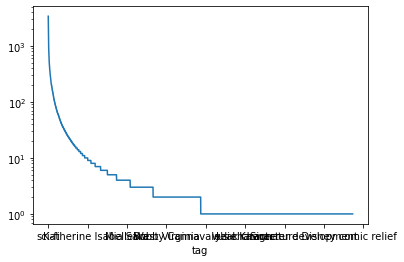

In [15]:
tag_counts = tags.value_counts('tag')
tag_counts.plot(logy=True)

1447


/home/joey/Documents/Informatica/PhD/2020-2021/SI EDLAE/Code/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='tag'>

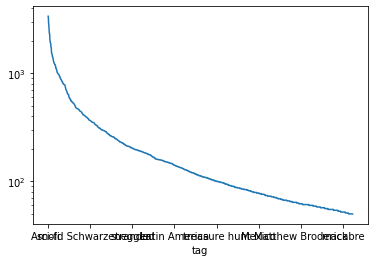

In [16]:
# remove tags that occur less than MIN_TAG_OCCURENCE times
MIN_TAG_OCCURENCE = 50
allowed_tags = tag_counts[tag_counts >= MIN_TAG_OCCURENCE].index
print(len(allowed_tags))
tags = tags[tags['tag'].isin(allowed_tags)]
tags.value_counts('tag').plot(logy=True)

In [17]:
tags = tags.groupby(ITEM_ID)['tag'].apply(lambda x: list(set(x)))
tags

movieId
1         [very good, fun, Disney animated feature, Want...
2         [Robin Williams, Fantasy, animals, CLV, time, ...
3         [NO_FA_GANES, CLV, sequel, comedy, Funniest Mo...
4                   [chick flick, revenge, CLV, characters]
5         [Fantasy, Comedy, sequel, wedding, CLV, remake...
                                ...                        
131054                                          [dinosaurs]
131082                                        [documentary]
131164                                        [Vietnam War]
131170                                  [alternate reality]
131258                                            [pirates]
Name: tag, Length: 16267, dtype: object

In [18]:
items = items.join(tags, on=ITEM_ID)
items['tag'] = items['tag'].apply(lambda d: d if isinstance(d, list) else [])
items

,movieId,genres,tag
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]","[very good, fun, Disney animated feature, Want..."
1,2,"[Adventure, Children, Fantasy]","[Robin Williams, Fantasy, animals, CLV, time, ..."
2,3,"[Comedy, Romance]","[NO_FA_GANES, CLV, sequel, comedy, Funniest Mo..."
3,4,"[Comedy, Drama, Romance]","[chick flick, revenge, CLV, characters]"
4,5,[Comedy],"[Fantasy, Comedy, sequel, wedding, CLV, remake..."
...,...,...,...
27271,131250,[Comedy],[]
27272,131252,"[Comedy, Horror]",[]
27273,131254,[Comedy],[]
27274,131256,[Comedy],[]


### IMDB info

In [19]:
links = pd.read_csv(IMDB_ID_PATH, usecols=[ITEM_ID, 'imdbId'])
links = links[links[ITEM_ID].isin(used_items)]
links['imdbId'] = links['imdbId'].apply(lambda x: f'tt{x:07d}')
links

,movieId,imdbId
0,1,tt0114709
1,2,tt0113497
2,3,tt0113228
3,4,tt0114885
4,5,tt0113041
...,...,...
27271,131250,tt0248409
27272,131252,tt0289477
27273,131254,tt0466713
27274,131256,tt0277703


In [20]:
imdb_info = pd.read_csv(IMDB_BASICS_PATH, sep='\t', usecols=['tconst', 'startYear', 'runtimeMinutes']).set_index('tconst')
links = links.join(imdb_info, on='imdbId')
del imdb_info
links

/home/joey/Documents/Informatica/PhD/2020-2021/SI EDLAE/Code/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,movieId,imdbId,startYear,runtimeMinutes
0,1,tt0114709,1995,81
1,2,tt0113497,1995,104
2,3,tt0113228,1995,101
3,4,tt0114885,1995,124
4,5,tt0113041,1995,106
...,...,...,...,...
27271,131250,tt0248409,2000,99
27272,131252,tt0289477,2000,10
27273,131254,tt0466713,2007,85
27274,131256,tt0277703,2002,83


In [21]:
imdb_info = pd.read_csv(IMDB_CREW_PATH, sep='\t').set_index('tconst')
links = links.join(imdb_info, on='imdbId')
imdb_info
del imdb_info
links

,movieId,imdbId,startYear,runtimeMinutes,directors,writers
0,1,tt0114709,1995,81,nm0005124,"nm0005124,nm0230032,nm0004056,nm0710020,nm0923..."
1,2,tt0113497,1995,104,nm0002653,"nm0378144,nm0852430,nm0833164,nm0885575"
2,3,tt0113228,1995,101,nm0222043,nm0425756
3,4,tt0114885,1995,124,nm0001845,"nm0573334,nm0060103"
4,5,tt0113041,1995,106,nm0796124,"nm0352443,nm0329304,nm0583600,nm0796124"
...,...,...,...,...,...,...
27271,131250,tt0248409,2000,99,nm0678450,"nm0678450,nm0940008"
27272,131252,tt0289477,2000,10,"nm1013666,nm0905953","nm0905953,nm1013666"
27273,131254,tt0466713,2007,85,nm0377153,"nm0298756,nm0377153,nm0517282,nm2047532,nm2047699"
27274,131256,tt0277703,2002,83,nm0227845,"nm0227845,nm0728894"


#### Bin numerical variables

In [22]:
links['startYear'] = pd.qcut(links['startYear'].astype(np.float), 10)

In [23]:
# links['runtimeMinutes'].unique()
links['runtimeMinutes'].replace('\\N', np.nan, inplace=True)

In [24]:
links['runtimeMinutes'] = pd.qcut(links['runtimeMinutes'].astype(np.float), 10)

#### Transform lists

In [25]:
def stack_list(series):
    return series.apply(pd.Series).stack()

def create_list_filter(f):
    """ Creates a filter function to apply to a list. """
    def filt(l):
        return list(filter(f, l))
    return filt

In [26]:
links['directors'] = links['directors'].fillna('').apply(lambda x: x.split(','))
links['writers'] = links['writers'].fillna('').apply(lambda x: x.split(','))

In [27]:
links

,movieId,imdbId,startYear,runtimeMinutes,directors,writers
0,1,tt0114709,"(1993.0, 1998.0]","(80.0, 88.0]",[nm0005124],"[nm0005124, nm0230032, nm0004056, nm0710020, n..."
1,2,tt0113497,"(1993.0, 1998.0]","(103.0, 108.0]",[nm0002653],"[nm0378144, nm0852430, nm0833164, nm0885575]"
2,3,tt0113228,"(1993.0, 1998.0]","(99.0, 103.0]",[nm0222043],[nm0425756]
3,4,tt0114885,"(1993.0, 1998.0]","(115.0, 127.0]",[nm0001845],"[nm0573334, nm0060103]"
4,5,tt0113041,"(1993.0, 1998.0]","(103.0, 108.0]",[nm0796124],"[nm0352443, nm0329304, nm0583600, nm0796124]"
...,...,...,...,...,...,...
27271,131250,tt0248409,"(1998.0, 2002.0]","(95.0, 99.0]",[nm0678450],"[nm0678450, nm0940008]"
27272,131252,tt0289477,"(1998.0, 2002.0]","(0.999, 80.0]","[nm1013666, nm0905953]","[nm0905953, nm1013666]"
27273,131254,tt0466713,"(2006.0, 2009.0]","(80.0, 88.0]",[nm0377153],"[nm0298756, nm0377153, nm0517282, nm2047532, n..."
27274,131256,tt0277703,"(1998.0, 2002.0]","(80.0, 88.0]",[nm0227845],"[nm0227845, nm0728894]"


9702


/home/joey/Documents/Informatica/PhD/2020-2021/SI EDLAE/Code/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

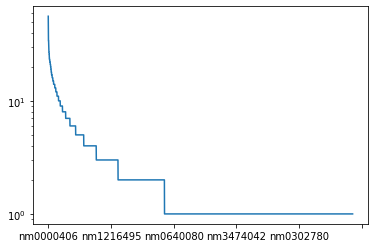

In [28]:
counts = stack_list(links['directors']).value_counts()
print(len(counts))
counts.plot(logy=True)

In [29]:
MIN_DIRECTOR_OCCURRENCES = 4
allowed = counts[counts > MIN_DIRECTOR_OCCURRENCES]
print(len(allowed))
links['directors'] = links['directors'].apply(create_list_filter(lambda y: y in allowed.index))

1130


22781


/home/joey/Documents/Informatica/PhD/2020-2021/SI EDLAE/Code/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

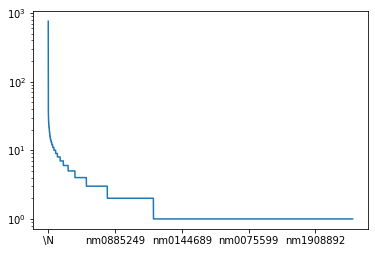

In [30]:
counts = stack_list(links['writers']).value_counts()
print(len(counts))
counts.plot(logy=True)

In [31]:
MIN_WRITER_OCCURRENCES = 7
allowed = counts[counts > MIN_WRITER_OCCURRENCES]
print(len(allowed))
links['writers'] = links['writers'].apply(create_list_filter(lambda y: y in allowed.index))

888


In [32]:
links

,movieId,imdbId,startYear,runtimeMinutes,directors,writers
0,1,tt0114709,"(1993.0, 1998.0]","(80.0, 88.0]",[nm0005124],"[nm0005124, nm0004056, nm0710020, nm0923736, n..."
1,2,tt0113497,"(1993.0, 1998.0]","(103.0, 108.0]",[nm0002653],[nm0378144]
2,3,tt0113228,"(1993.0, 1998.0]","(99.0, 103.0]",[nm0222043],[nm0425756]
3,4,tt0114885,"(1993.0, 1998.0]","(115.0, 127.0]",[],[nm0060103]
4,5,tt0113041,"(1993.0, 1998.0]","(103.0, 108.0]",[nm0796124],"[nm0352443, nm0329304, nm0583600, nm0796124]"
...,...,...,...,...,...,...
27271,131250,tt0248409,"(1998.0, 2002.0]","(95.0, 99.0]",[],[]
27272,131252,tt0289477,"(1998.0, 2002.0]","(0.999, 80.0]",[],[]
27273,131254,tt0466713,"(2006.0, 2009.0]","(80.0, 88.0]",[],[]
27274,131256,tt0277703,"(1998.0, 2002.0]","(80.0, 88.0]",[],[]


In [33]:
items = items.join(links.set_index(ITEM_ID), on=ITEM_ID).drop(columns=['imdbId'])
items

,movieId,genres,tag,startYear,runtimeMinutes,directors,writers
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]","[very good, fun, Disney animated feature, Want...","(1993.0, 1998.0]","(80.0, 88.0]",[nm0005124],"[nm0005124, nm0004056, nm0710020, nm0923736, n..."
1,2,"[Adventure, Children, Fantasy]","[Robin Williams, Fantasy, animals, CLV, time, ...","(1993.0, 1998.0]","(103.0, 108.0]",[nm0002653],[nm0378144]
2,3,"[Comedy, Romance]","[NO_FA_GANES, CLV, sequel, comedy, Funniest Mo...","(1993.0, 1998.0]","(99.0, 103.0]",[nm0222043],[nm0425756]
3,4,"[Comedy, Drama, Romance]","[chick flick, revenge, CLV, characters]","(1993.0, 1998.0]","(115.0, 127.0]",[],[nm0060103]
4,5,[Comedy],"[Fantasy, Comedy, sequel, wedding, CLV, remake...","(1993.0, 1998.0]","(103.0, 108.0]",[nm0796124],"[nm0352443, nm0329304, nm0583600, nm0796124]"
...,...,...,...,...,...,...,...
27271,131250,[Comedy],[],"(1998.0, 2002.0]","(95.0, 99.0]",[],[]
27272,131252,"[Comedy, Horror]",[],"(1998.0, 2002.0]","(0.999, 80.0]",[],[]
27273,131254,[Comedy],[],"(2006.0, 2009.0]","(80.0, 88.0]",[],[]
27274,131256,[Comedy],[],"(1998.0, 2002.0]","(80.0, 88.0]",[],[]


In [34]:
items = items.set_index(ITEM_ID)

## Map metadata to one hot features

In [35]:
def get_dummies(df):
    return pd.get_dummies(df, prefix_sep='_', sparse=False)

def get_list_dummies(series):
    """ Creates dummies for list type. kwargs are passed to get_dummies(). """
    return get_dummies(stack_list(series)).groupby(level=0).sum()

In [36]:
list_types = ['genres', 'tag', 'directors', 'writers']
categorical_types = ['startYear', 'runtimeMinutes']

In [37]:
metadata = get_dummies(items[categorical_types])
metadata

,"startYear_(1892.999, 1956.0]","startYear_(1956.0, 1973.0]","startYear_(1973.0, 1985.7]","startYear_(1985.7, 1993.0]","startYear_(1993.0, 1998.0]","startYear_(1998.0, 2002.0]","startYear_(2002.0, 2006.0]","startYear_(2006.0, 2009.0]","startYear_(2009.0, 2011.0]","startYear_(2011.0, 2016.0]","runtimeMinutes_(0.999, 80.0]","runtimeMinutes_(80.0, 88.0]","runtimeMinutes_(88.0, 91.0]","runtimeMinutes_(91.0, 95.0]","runtimeMinutes_(95.0, 99.0]","runtimeMinutes_(99.0, 103.0]","runtimeMinutes_(103.0, 108.0]","runtimeMinutes_(108.0, 115.0]","runtimeMinutes_(115.0, 127.0]","runtimeMinutes_(127.0, 931.0]"
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131250,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
131252,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
131254,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [38]:
for col in list_types:
    dummies = get_list_dummies(items[col])
    metadata = pd.concat([metadata, dummies], axis=1)

In [39]:
# Set zeros to nan for sparse saving
metadata[metadata == 0] = np.nan
metadata[ITEM_ID] = metadata.index
metadata

,"startYear_(1892.999, 1956.0]","startYear_(1956.0, 1973.0]","startYear_(1973.0, 1985.7]","startYear_(1985.7, 1993.0]","startYear_(1993.0, 1998.0]","startYear_(1998.0, 2002.0]","startYear_(2002.0, 2006.0]","startYear_(2006.0, 2009.0]","startYear_(2009.0, 2011.0]","startYear_(2011.0, 2016.0]",...,nm1303925,nm1321655,nm1321656,nm1347153,nm1557594,nm1615610,nm1729303,nm1733317,nm5022110,movieId
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
5,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131250,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131250
131252,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131252
131254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131254


## Filter metadata (if needed)

In [40]:
# amount of occurences per feature
metadata.sum(axis=0).sort_values()

intelligent sci-fi            2.0
indiana jones                 4.0
nm0687042                     5.0
nm0959062                     5.0
nm1013671                     5.0
                         ...     
Thriller                   3228.0
Romance                    3259.0
Comedy                     6586.0
Drama                     10458.0
movieId               982370638.0
Length: 3505, dtype: float64

In [41]:
# amount of features per item
metadata.drop(columns=[ITEM_ID]).sum(axis=1).sort_values()

movieId
129705      2.0
127007      2.0
125531      2.0
1316        2.0
644         2.0
          ...  
79132     104.0
32587     112.0
2959      120.0
356       127.0
296       162.0
Length: 20720, dtype: float64

## Remap ids

In [42]:
util.remap_ids(interactions, metadata, col=ITEM_ID)
util.remap_ids(interactions, col=USER_ID)[0]

/home/joey/Documents/Informatica/PhD/2020-2021/SI EDLAE/Code/teaser/util.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = id_mapping[df[col]].values


,userId,movieId
6,0,150
7,0,221
8,0,251
9,0,258
10,0,291
...,...,...
20000256,138286,12833
20000257,138286,12977
20000258,138286,13050
20000259,138286,13147


## Convert to csr matrix

In [43]:
X = util.interactions_df_to_csr(interactions, ITEM_ID, USER_ID)
X

<138287x20720 sparse matrix of type '<class 'numpy.int8'>'
	with 9995410 stored elements in Compressed Sparse Row format>

## Print statistics

In [44]:
amt_users, amt_items = X.shape
i_density = X.getnnz() / (amt_users * amt_items)
metadata_names = categorical_types + list_types
S = scipy.sparse.csr_matrix(metadata.set_index(ITEM_ID).values.astype(np.int8))
_, amt_features = S.shape
f_density = S.getnnz() / (amt_features * amt_items)

print(f"# users: {amt_users}")
print(f"# items: {amt_items}")
print(f"inter. density: {i_density:.3%}")
print(f"columns: {', '.join(metadata_names)}")
print(f"# features: {amt_features}")
print(f"feature density: {f_density:.3%}")

# users: 138287
# items: 20720
inter. density: 0.349%
columns: startYear, runtimeMinutes, genres, tag, directors, writers
# features: 3504
feature density: 0.288%


## Split interactions with strong generalization scheme

In [45]:
Xtrainval, Xtest_in, Xtest_out = util.split(X, test_users=AMT_TEST_USERS, perc_history=PERC_HISTORY, min_interactions=VAL_MIN_ITEMS_PER_USER, seed=SEED)
Xtrain, Xval_in, Xval_out = util.split(Xtrainval, test_users=AMT_VAL_USERS, perc_history=PERC_HISTORY, min_interactions=VAL_MIN_ITEMS_PER_USER, seed=SEED)

## Save files

In [46]:
basename = OUTPUT_INTERACTIONS_PATH.stem

util.store_interactions(Xtrain, OUTPUT_DIR / f"{basename}.train.csv", item_id=T_ITEM_ID, user_id=T_USER_ID)
util.store_interactions(Xtest_in, OUTPUT_DIR / f"{basename}.testin.csv", item_id=T_ITEM_ID, user_id=T_USER_ID)
util.store_interactions(Xtest_out, OUTPUT_DIR / f"{basename}.testout.csv", item_id=T_ITEM_ID, user_id=T_USER_ID)
util.store_interactions(Xval_in, OUTPUT_DIR / f"{basename}.valin.csv", item_id=T_ITEM_ID, user_id=T_USER_ID)
util.store_interactions(Xval_out, OUTPUT_DIR / f"{basename}.valout.csv", item_id=T_ITEM_ID, user_id=T_USER_ID)

metadata.rename(columns={ITEM_ID: T_ITEM_ID}).to_csv(OUTPUT_FEATURES_PATH, index=False)